# [NEW]프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

## 프로젝트 1-1

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

(371, 660, 3)


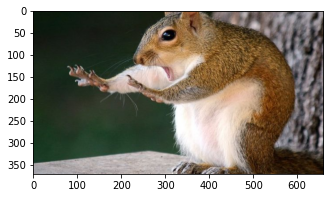

In [2]:
# 고해상도 이미지 불러오기
hr_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/ddaramji.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
hr_shape = hr_image.shape[:2]

print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(92, 165, 3)


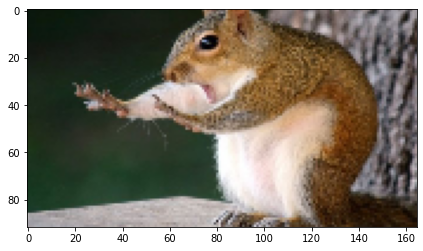

In [3]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(hr_image.shape[1]//4,
                                       hr_image.shape[0]//4)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(8,4))
plt.imshow(lr_image)

In [4]:
# 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)

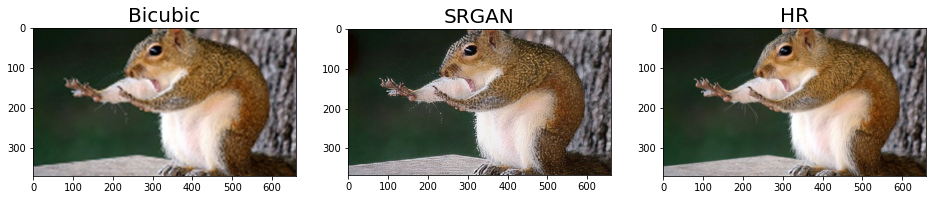

In [6]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

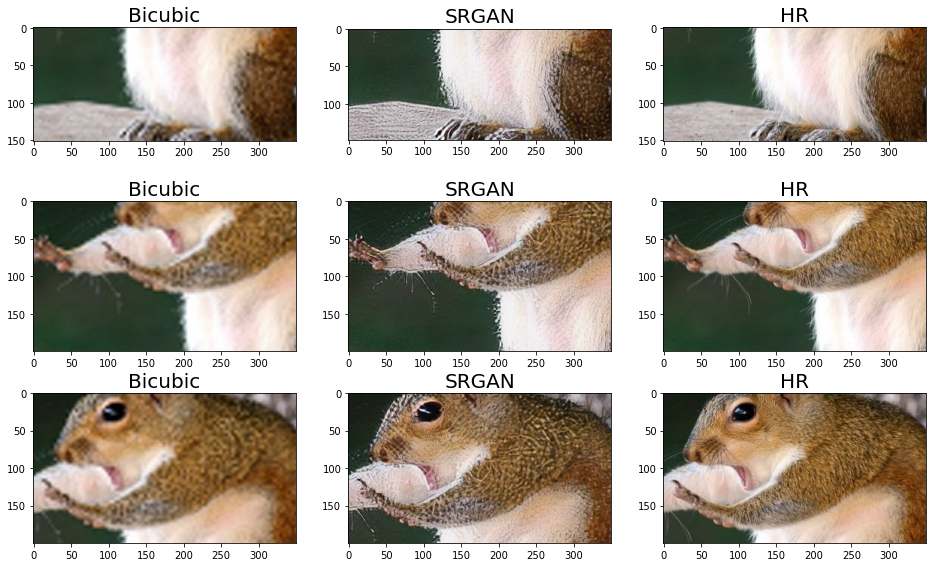

In [7]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=200, y=350):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

Bicubic보다는 확실히 SRGAN이 좀 더 선명함이 있긴 하다   
하지만 아무래도 이미지에 있는 털이 자글자글 하다보니 SRGAN이라도 이를 부드럽게 표현하기보단 더 과장되어 나온 것으로 보인다.   

## 프로젝트 1-2

(240, 320, 3)


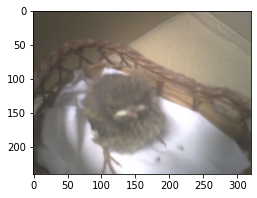

In [12]:
# 저해상도 이미지 불러오기
image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/whajilguji.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_shape = image.shape[:2]

print(image.shape)

plt.figure(figsize=(6,3))
plt.imshow(image)

# 화질구지 가져왔습니다ㅎㅎ

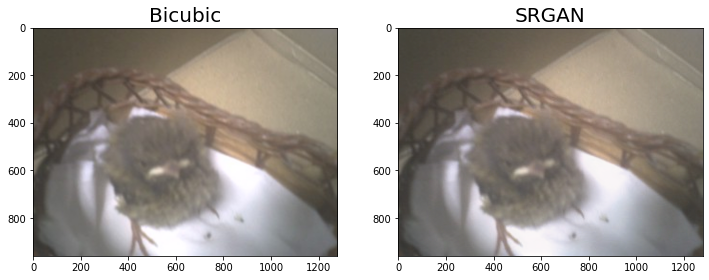

In [13]:
srgan_hr = apply_srgan(image)

# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    image, 
    dsize=(image.shape[1]*4, image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

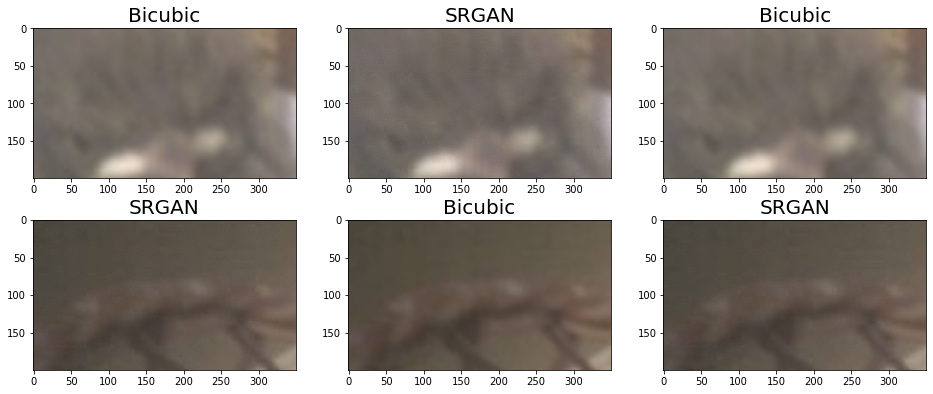

In [15]:
# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(420,400)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    
    plt.title(title, fontsize=20)

너무 화질구지라 그런지... 그렇게까지 화질이 오르진 않았다.ㅠㅠㅠㅠ

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성

## 1. gif 파일 불러오기

In [16]:
import os
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture(os.getenv('HOME') +'/aiffel/super_resolution/wine_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 13
frame 크기 : (340, 355, 3)


## 2. 프레임별 Super Resolution 진행하기

In [17]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

    frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

## 3. 프레임을 합쳐 gif 만들기

In [18]:
import imageio

imageio.mimsave((os.getenv('HOME') +'/aiffel/super_resolution/wine_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave((os.getenv('HOME') +'/aiffel/super_resolution/wine_hr_srgan.gif'), frames_sr_srgan)

## 4. Jupyter notebook에 gif 표시하기

![wine_lr](wine_lr.gif "segment")

![wine_lr](wine_hr_bicubic.gif "segment")

![wine_lr](wine_hr_srgan.gif "segment")

- 확실히 GIF도 선명해졌음은 보여진다.
- 다만 위에 다람쥐 사진과 같이 조금 더 과장되어 보여지는 게 있어서 오히려 조금 부드럽게 후처리가 필요해 보인다.